# Семинар 5: стационарность и эргодичность

**Стационарность** - это свойство процесса не менять некоторые характеристики своего распределения с течением времени.
Разделяют **стационарность в узком смысле** - инвариантность конечномерных распределений относительно сдвига по времени - и **стационарность в широком смысле** - инвариантность первых двух моментов сечения процесса.

**Эргодичность** - это свойство процесса, позволяющее в некотором смысле заменить усреднене по исходам усреднением по времени.
В частности, процесс $ X $ называется **эргодическим по математическому ожиданию**, если $ \mathbb{E} X_t = m = const $ и

$$
    \DeclareMathOperator*{\limmeansq}{\text{l.i.m.}}
    m = \limmeansq_{\tau \to +\infty} \frac{1}{\tau} \int\limits_0^\tau X_t \, dt
$$

**Задача:**

Дан случайный процесс $ S_t = A \exp(at + \sigma W_t) $, $ t \geqslant 1 $,
где $ A $, $ a $, $ \sigma $ - неслучайные константы.
Воспользовавшись понятием эргодичности, оценить величину $ a $.

**Решение:**

В конспекте семинара показано, что случайный процесс

$$
    X_t = \frac{1}{t} \ln \frac{S_t}{A} = a + \frac{W_t}{t}, \qquad t \geqslant 1
$$

является эргодическим по математическому ожиданию.
Воспользуемся этим и, промоделировав несколько реализаций $ S_t $,
по каждой оценим параметр $ a $ и сравним с истинным.

*Замечание:*

Приведённый процесс является моделью Блэка-Шоулса-Мертона динамики цены акций.

In [1]:
import numpy as np
import pandas as pd

# Фиксируем зерно для генертора случайных чисел.
np.random.seed(seed=42)

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

font = {'size'   : 14}
matplotlib.rc('font', **font)

In [3]:
# Раскомментировать, если следующая ячейка не работает.
#import sys
#sys.path.insert(1, ".")

In [4]:
from utils.plots import plot_realizations, plot_slices, plot_correlation_function

In [5]:
from scipy.stats import norm

In [6]:
def generate_BSM_sp(T: np.ndarray, A: float=1.0, a: float=0.1, sigma: float=0.1, realizations_number: int=25) -> np.ndarray:
    """
    Сгенерировать realizations_number реализаций процесса из модели Блэка-Шоулса-Мертона.
    
    Параметры
    ---------
    T : np.ndarray
        Сетка по времени.
    A : float, optional
        Начальная стоимость акций.
    a : float, optional
        Параметр экспоненциального тренда.
    sigma : float, optional
        Параметр волтатильности.
    realizations_number : int
        Число реализаций, которое требуется сгенерировать.
    """
    
    T = np.sort(T)
    assert T[0] >= 0.0
    realizations = np.zeros((realizations_number, T.shape[0]))
    
    # Для каждого очередного момента времени производится независимая генерация произошедших
    # на пройденном интервале скачков согласно нормальному распределению с нулевым средним и дисперсией \Delta t.
    step_rv = norm()
    realizations[:,0] = T[0] * step_rv.rvs((realizations_number)) # Если уж совсем честно генерировать, надо учесть, что T может начинаться не с нуля.
    for index in range(T.shape[0] - 1):
        realizations[:,index + 1] = realizations[:,index] + np.sqrt(T[index+1] - T[index])*step_rv.rvs((realizations_number))
        
    # Явная связь процесса с Винеровским.
    realizations = A * np.exp(a * T + sigma * realizations)
    
    return realizations

In [7]:
T_1 = np.linspace(0.0, 30.0, 500)
true_a = 0.05
BSM_sp = generate_BSM_sp(T_1, a=true_a, sigma=0.1, realizations_number=10)

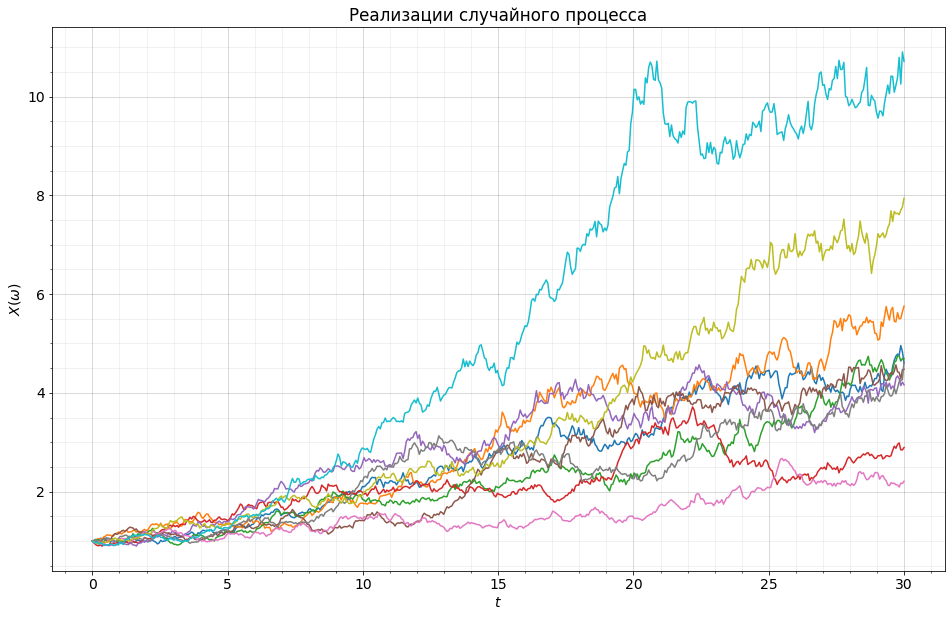

In [8]:
plot_realizations(T_1, BSM_sp)

In [9]:
def estimate_a_from_BSM_sp(T: np.ndarray, BSM_sp: np.ndarray) -> np.ndarray:
    """
    Оценить параметр a в модели Блэка-Шоулса-Мертона по траектории.
    
    Параметры
    ---------
    T : np.ndarray
        Сетка по времени.
    BSM_sp : np.ndarray
        Массив реализаций случайного процесса Блэка-Шоулса-Мертона.
    """
    
    # Первую точку выкинем для избежания деления на ноль.
    X = np.log(BSM_sp[:,1:] / BSM_sp[:,0,None]) / T[1:]
    
    # Воспользуемся формулой трапеций.
    dT = T[2:] - T[1:-1]
    a = np.sum(0.5 * (X[:,1:] + X[:,:-1]) * dT, axis=1) / (T[-1] - T[0])
    
    return a

In [10]:
estimated_a = estimate_a_from_BSM_sp(T_1, BSM_sp)
print(f"Среднаяя относительная абсолютная ошибка оценки параметра a: {np.mean(np.abs(estimated_a - true_a) / abs(true_a)):.2f}")

Среднаяя относительная абсолютная ошибка оценки параметра a: 0.24


Ошибки порядка 30% в среднем. Это связано со сравнительно большим значением параметра $ \sigma $, отвечающего за "шумовую" составляющую.